# don't be plastic, elastipy!

Hi there, this tutorial is actually a [jupyter notebook](https://jupyter.org/) and can be found in [examples](https://github.com/netzkolchose/elastipy/blob/development/examples/)/[tutorial.ipynb](https://github.com/netzkolchose/elastipy/blob/development/examples/tutorial.ipynb)

In [1]:
# hidden

# here we just add the parent path of this notebook to 
# the path list where python modules are searched.
# So we find elastipy even if it's not installed via setup.py
import sys
sys.path.insert(0, "..")

## exporting some objects

Without too much thinking we can just use the built-in export helper
and generate some data.

In [2]:
from elastipy import Exporter

class ShapeExporter(Exporter):
    INDEX_NAME = "elastipy-example-shapes"
    MAPPINGS = {
        "properties": {
            "shape": {"type": "keyword"},
            "color": {"type": "keyword"},
            "area": {"type": "float"},
        }
    }

The `INDEX_NAME` is obviously the name of the elasticsearch index. 
The `MAPPINGS` parameter describes the 
[elasticsearch mapping](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html). 
Here we say that documents will at least have these common fields, 
one of type `float` and two of type `keyword` which means they 
are strings but not full-text searchable ones. Instead they are 
efficiently indexed and aggregatable.

The data we create out of thin air.. 

In [3]:
import random

def shape_generator(count=1000, seed=42):
    rnd = random.Random(seed)
    for i in range(count):
        yield {
            "shape": rnd.choice(("triangle", "square")),
            "color": rnd.choice(("red", "green", "blue")),
            "area": rnd.gauss(5, 1.3),
        }

Now create our exporter and export a couple of documents. It uses the [bulk helper tools](https://elasticsearch-py.readthedocs.io/en/7.10.0/helpers.html#bulk-helpers) internally.

In [4]:
exporter = ShapeExporter()

count, errors = exporter.export_list(shape_generator(), refresh=True)

print(count, "exported")

1000 exported


The `refresh=True` parameter will refresh the index as soon as everything is exported, so we do not have to wait for objects to appear in the elasticsearch index. 

## query oh elastipyia 

In most cases this import is enough to access all the good stuff:

In [5]:
from elastipy import Search, query

Now get some documents:

In [6]:
s = Search(index="elastipy-example-shapes")

**s** is now a search request that can be configured. Setting any search related options will always return a new instance. Here we set the maximum number of documents to respond:

In [7]:
s = s.size(3)

Next we add a [query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html), more specifically a [term query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-term-query.html).

In [8]:
s = s.term(field="color", value="green")

Our request to elasticsearch would look like this right now:

In [9]:
s.dump.body()

{
  "query": {
    "term": {
      "color": {
        "value": "green"
      }
    }
  },
  "size": 3
}


More queries can be added, which defaults to an **AND** combination:

In [10]:
s = s.range(field="area", gt=5.)
s.dump.body()

{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "color": {
              "value": "green"
            }
          }
        },
        {
          "range": {
            "area": {
              "gt": 5.0
            }
          }
        }
      ]
    }
  },
  "size": 3
}


**OR** combinations can be archived with the [bool](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-bool-query.html) query itself or by applying the `|` operator to the query classes in `elastipy.query`:

In [11]:
s = s | (query.Term(field="color", value="red") & query.Range(field="area", gt=8.))
s.dump.body()

{
  "query": {
    "bool": {
      "should": [
        {
          "bool": {
            "must": [
              {
                "term": {
                  "color": {
                    "value": "green"
                  }
                }
              },
              {
                "range": {
                  "area": {
                    "gt": 5.0
                  }
                }
              }
            ]
          }
        },
        {
          "bool": {
            "must": [
              {
                "term": {
                  "color": {
                    "value": "red"
                  }
                }
              },
              {
                "range": {
                  "area": {
                    "gt": 8.0
                  }
                }
              }
            ]
          }
        }
      ]
    }
  },
  "size": 3
}


Better execute the search now before the body get's too complicated:

In [12]:
response = s.execute()
response.dump()

{
  "took": 1,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 555,
      "relation": "eq"
    },
    "max_score": 2.1872303,
    "hits": [
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "C3DCWncBlYGgD6s6OvQY",
        "_score": 2.1872303,
        "_source": {
          "shape": "square",
          "color": "red",
          "area": 9.422362274394294
        }
      },
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "S3DCWncBlYGgD6s6OvQY",
        "_score": 2.1872303,
        "_source": {
          "shape": "triangle",
          "color": "red",
          "area": 8.011022752102972
        }
      },
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "b3DCWncBlYGgD6s6OvQY",
        "_score": 2.1872303,
        "_source": {
          "shape": "square",
 

The response object is a small wrapper around `dict` that has some convenience properties.

In [13]:
response.documents

[{'shape': 'square', 'color': 'red', 'area': 9.422362274394294},
 {'shape': 'triangle', 'color': 'red', 'area': 8.011022752102972},
 {'shape': 'square', 'color': 'red', 'area': 8.001834685241512}]

How many documents are there at all?

In [14]:
Search(index="elastipy-example-shapes").execute().total_hits

3000

---

The functions and properties are tried to make chainable in a way that allows for short and powerful oneliners: 

In [15]:
Search(index="elastipy-example-shapes") \
    .size(20).sort("-area").execute().documents

[{'shape': 'triangle', 'color': 'red', 'area': 10.609408732815844},
 {'shape': 'triangle', 'color': 'red', 'area': 10.609408732815844},
 {'shape': 'triangle', 'color': 'red', 'area': 10.609408732815844},
 {'shape': 'square', 'color': 'blue', 'area': 9.785991184126697},
 {'shape': 'square', 'color': 'blue', 'area': 9.785991184126697},
 {'shape': 'square', 'color': 'blue', 'area': 9.785991184126697},
 {'shape': 'square', 'color': 'red', 'area': 9.422362274394294},
 {'shape': 'square', 'color': 'red', 'area': 9.422362274394294},
 {'shape': 'square', 'color': 'red', 'area': 9.422362274394294},
 {'shape': 'triangle', 'color': 'blue', 'area': 9.24591971667655},
 {'shape': 'triangle', 'color': 'blue', 'area': 9.24591971667655},
 {'shape': 'triangle', 'color': 'blue', 'area': 9.24591971667655},
 {'shape': 'square', 'color': 'blue', 'area': 9.11442473191995},
 {'shape': 'square', 'color': 'blue', 'area': 9.11442473191995},
 {'shape': 'square', 'color': 'blue', 'area': 9.11442473191995},
 {'shap

So that was rambling about the filtering and the documents in the response. There is a lot of functionality in elasticsearch that is not covered by this library right now. To move on in happiness we just start the next chapter.

## agitated aggregation

Aggregations can be created using the `agg_`, `metric_` and `pipeline_` prefixes. An aggregation is **attached** to the `Search` instance, so there is no copying like with the queries above.

In [16]:
s = Search(index="elastipy-example-shapes").size(0)

agg = s.agg_terms(field="shape")

s.dump.body()

{
  "aggregations": {
    "a0": {
      "terms": {
        "field": "shape"
      }
    }
  },
  "query": {
    "match_all": {}
  },
  "size": 0
}


As we can see, a [terms aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-terms-aggregation.html)
has been added to the search body. The names of aggregations are auto-generated, but can be explicitly stated:

In [17]:
s = Search(index="elastipy-example-shapes").size(0)

agg = s.agg_terms("shapes", field="shape")

s.dump.body()

{
  "aggregations": {
    "shapes": {
      "terms": {
        "field": "shape"
      }
    }
  },
  "query": {
    "match_all": {}
  },
  "size": 0
}


Let's look at the result from elasticsearch:

In [18]:
s.execute().dump()

{
  "took": 1,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 3000,
      "relation": "eq"
    },
    "max_score": null,
    "hits": []
  },
  "aggregations": {
    "shapes": {
      "doc_count_error_upper_bound": 0,
      "sum_other_doc_count": 0,
      "buckets": [
        {
          "key": "square",
          "doc_count": 1539
        },
        {
          "key": "triangle",
          "doc_count": 1461
        }
      ]
    }
  }
}


### valuable access

Because we kept the `agg` variable, we can use it's interface to access the values more conveniently:

In [19]:
agg.to_dict()

{'square': 1539, 'triangle': 1461}

It supports the `items()`, `keys()` and `values()` generators as known from the `dict` type:

In [20]:
for key, value in agg.items():
    print(f"{key:12} {value}")

square       1539
triangle     1461


It also has a `dict_rows()` generator which preserves the **names** and **keys** of the aggregations:

In [21]:
for row in agg.dict_rows():
    print(row)

{'shapes': 'square', 'shapes.doc_count': 1539}
{'shapes': 'triangle', 'shapes.doc_count': 1461}


The `rows()` generator flattens the `dict_rows()` into a CSV-style list:

In [22]:
for row in agg.rows():
    print(row)

['shapes', 'shapes.doc_count']
['square', 1539]
['triangle', 1461]


And we can print a nice table to the command-line:

In [23]:
agg.dump.table(colors=False)

shapes   │ shapes.doc_count                            
─────────┼─────────────────────────────────────────────
square   │ 1539 ██████████████████████████████████████▉
triangle │ 1461 █████████████████████████████████████  


(The `colors=False` parameter disables console colors because they do not work in this documentation)  

---
Obviously, at this point a couple of users would not understand why there is no conversion to a 
[pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) built in:

In [24]:
agg.to_pandas()  # or simply agg.df()

,shapes,shapes.doc_count
0,square,1539
1,triangle,1461


The **columns** are assigned automatically. 

Columns containing ISO-formatted date strings will be converted to `pandas.Timestamp`.

The DataFrame [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.html#pandas.Index)
column can be assigned with the `index` and `to_index` parameters.

`index` simply copies the column:

In [25]:
agg.to_pandas(index="shapes")

,shapes,shapes.doc_count
shapes,,
square,square,1539
triangle,triangle,1461


`to_index` will **move** the column:

In [26]:
agg.to_pandas(to_index="shapes")

,shapes.doc_count
shapes,
square,1539
triangle,1461


With `matplotlib` installed we can access the [pandas plotting interface](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html):  

<AxesSubplot:xlabel='shapes'>

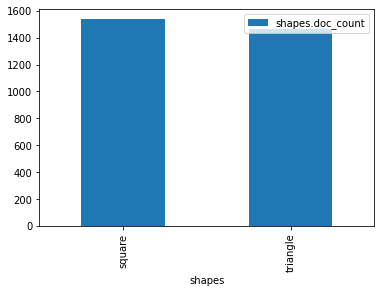

In [27]:
agg.df(to_index="shapes").plot.bar()

Satisfied with a little graphic we feel more confident and look into the details of **metrics** and nested **bucket** aggregations.

### deeper aggregation agitation 

In [35]:
agg = Search(index="elastipy-example-shapes") \
    .agg_terms("shapes", field="shape") \
    .agg_terms("colors", field="color") \
    .metric_sum("area", field="area") \
    .metric_avg("area-avg", field="area") \
    .execute()

A few notes:

  - `agg_` methods always return the newly created aggregation, so the `colors` aggregation is nested inside the `shapes` aggregation.
  - `metric_` methods return their parent aggregation (because metrics do not allow a nested aggregation), so we can just continue to call `metric_*` and each time we add a metric to the `colors` aggregation. If you need to get access to the metric object itself add the `return_self=True` parameter.
  - The `execute` method on an aggregation does not return the response but the aggregation itself.
  
Now, what does the `to_dict` output look like?

In [29]:
agg.to_dict()

{('square', 'blue'): 534,
 ('square', 'green'): 510,
 ('square', 'red'): 495,
 ('triangle', 'blue'): 531,
 ('triangle', 'green'): 510,
 ('triangle', 'red'): 420}

It has put the **keys** that lead to each value into tuples. Without a lot of thinking we can say:

In [30]:
data = agg.to_dict()
print(f"There are {data[('triangle', 'red')]} red triangles in the database!")

There are 420 red triangles in the database!


But where are the metrics gone?

Generally, `keys()`, `values()`, `items()`, `to_dict()` and `to_matrix()` only access the values of the **current aggregation** (which is `colors` in the example). Although all the keys of the parent **bucket** aggregations that lead to the values are included.

The methods `dict_rows()`, `rows()`, `to_pandas()` and `.dump.table()` will access **all values** from the whole aggregation branch. In this example the branch looks like this:

- shapes
  - colors
    - area
    - area-avg

In [31]:
agg.dump.table(digits=3, colors=False)

shapes   │ shapes.doc_count    │ colors │ colors.doc_count    │ area                    │ area-avg            
─────────┼─────────────────────┼────────┼─────────────────────┼─────────────────────────┼─────────────────────
square   │ 1539 ██████████████ │ blue   │ 534 ███████████████ │ 2761.807 ██████████████ │ 5.172 █████████████▉
square   │ 1539 ██████████████ │ green  │ 510 ██████████████▍ │ 2647.929 █████████████▌ │ 5.192 ██████████████
square   │ 1539 ██████████████ │ red    │ 495 █████████████▉  │ 2544.687 ████████████▉  │ 5.141 █████████████▉
triangle │ 1461 █████████████▍ │ blue   │ 531 ██████████████▉ │ 2673.593 █████████████▋ │ 5.035 █████████████▋
triangle │ 1461 █████████████▍ │ green  │ 510 ██████████████▍ │ 2504.096 ████████████▊  │  4.91 █████████████▍
triangle │ 1461 █████████████▍ │ red    │ 420 ███████████▉    │ 2112.996 ██████████▉    │ 5.031 █████████████▋


Now all information is in the table. Note that the `shapes.doc_count` column contains the same value multiple times. This is because each `colors` aggregation bucket splits the `shapes` bucket into multiple results, without changing the overall count of the shapes, of course.

It's possible to move the keys of sub-aggregations into new columns with the `flat` parameter. Below we basically say: Drop the `colors` and `colors.doc_count` columns and instead create a column for each encountered color key. The names of following sub-aggregations and metrics are appended to each key. (Also the resulting `area-avg` columns are excluded to not hurt our eyes too much)

In [38]:
agg.dump.table(flat="colors", exclude="*avg", digits=3, colors=False)

shapes   │ shapes.doc_count │ blue       │ blue.area      │ green │ green.area      │ red      │ red.area     
─────────┼──────────────────┼────────────┼────────────────┼───────┼─────────────────┼──────────┼──────────────
square   │ 1539 ███████████ │ 534 ██████ │ 2761.807 █████ │ 510   │ 2647.929 ██████ │ 495 ████ │ 2544.687 ████
triangle │ 1461 ██████████▌ │ 531 █████▉ │ 2673.593 ████▊ │ 510   │ 2504.096 █████▋ │ 420 ███▌ │ 2112.996 ███▍


This can be useful for stacking bars in a plot:

<AxesSubplot:>

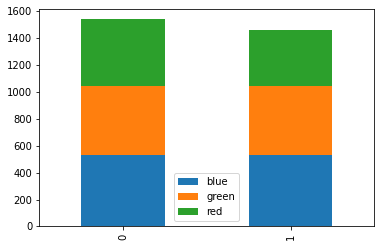

In [40]:
agg.df(flat="colors", exclude=("*doc_count", "*area*")).plot.bar(stacked=True)

---
Now what is this method with the awesome name `to_matrix`?

In [41]:
names, keys, matrix = agg.to_matrix()
print("names ", names)
print("keys  ", keys)
print("matrix", matrix)

names  ['shapes', 'colors']
keys   [['square', 'triangle'], ['blue', 'green', 'red']]
matrix [[534, 510, 495], [531, 510, 420]]


It produces a heatmap! At least in two dimensions. In this example we have two dimensions from the **bucket** aggregations `shapes` and `colors`. `to_matrix()` will produce a matrix with any number of dimensions, but if it's one or two, we can also convert it to a `DataFrame`:

In [33]:
agg.df_matrix()

,blue,green,red
square,534,510,495
triangle,531,510,420


To access the values of metrics we have to call `to_matrix` on a metric aggregation. Our `agg` parameter contains the `area` and `area-avg` metrics and we can reach it with the `children` property. Below is the heatmap of the average area. Except for the values nothing changed because metrics (and pipelines) do not contribute to the `key`s.

In [45]:
agg.children[1].df_matrix()

,blue,green,red
square,5.171923,5.192018,5.140783
triangle,5.035015,4.909992,5.030943


Having something like [seaborn](https://seaborn.pydata.org/) installed we can easily plot it:

<AxesSubplot:>

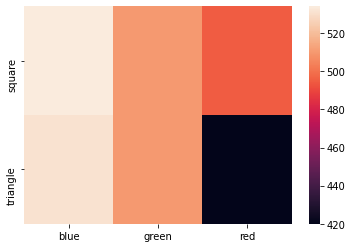

In [34]:
import seaborn as sns

sns.heatmap(agg.df_matrix())